In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import h5py
from typing import Tuple

### Dataset Loading, Visualize & Proprocessing

In [2]:
# Loading the data (cat/non-cat)
train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
test_dataset = h5py.File('data/test_catvnoncat.h5', "r")

train_X_orig = train_dataset['train_set_x'][:].reshape(209,-1).T  # (d, m)=(12288, 209);  first (209,64,64,3) to (209,12288) then to (12288, 209)
train_Y = train_dataset['train_set_y'][:].reshape(1,-1)           # (1, m)=(1, 209)

test_X_orig = test_dataset['test_set_x'][:].reshape(50,-1).T  # (12288, 50); dtype=uint8
test_Y = test_dataset['test_set_y'][:].reshape(1,-1)          # (1, 50); dtype=int64

train_X = train_X_orig/255.0    # dtype=float64
test_X = test_X_orig/255.0

In [3]:
print (f"Number of training examples: m_train = {train_X_orig.shape[1]}")
print (f"Number of testing examples: m_test = {test_X_orig.shape[1]}")
print ("Each image is of size: (64, 64, 3) \n")
print (f"train_X shape: {train_X.shape}")
print (f"train_Y shape: {train_Y.shape}")
print (f"test_X shape: {test_X.shape}")
print (f"test_Y shape: {test_Y.shape}")

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Each image is of size: (64, 64, 3) 

train_X shape: (12288, 209)
train_Y shape: (1, 209)
test_X shape: (12288, 50)
test_Y shape: (1, 50)


y = 1, it's a 'cat' picture.


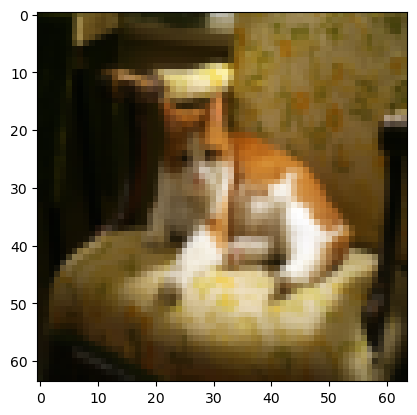

In [4]:
classes = test_dataset["list_classes"][:] # the list of classes
# Visualize sample picture
index = 7
plt.imshow(train_X_orig[:,index].reshape(64,64,3))
print (f"y = {int(train_Y[0, index])}, it's a '{classes[int(train_Y[0, index])].decode('utf-8')}' picture.")

### Epoch Function: Forward and Backward propagation

Forward Propagation:
- Input X
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$

Backward Propagation:
- Compute gardients <br>
$ dw = \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$ <br>
$ db = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$
- Update parameters <br>
$ w = w - \alpha \ dw$ <br>
$ b = b - \alpha \ db$

In [5]:
def epoch(X:np.ndarray, Y:np.ndarray, w:np.ndarray, b:np.float64, learning_rate:float=0.005)->Tuple[np.ndarray, np.float64, np.ndarray, np.float64, np.float64]:
    '''
    Perform one epoch(cycle) of training for NEURON[logistic regression]
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: int64
    w : numpy.ndarray [shape: (#features, 1)]
        array containing weights used by neuron; dtype: float64
    b : np.float64
        bias used by neuron
    learning_rate : float (default=0.05)   

    Returns
    -------
    w : updated array of learned weights by neuron
    b : updated learned bias by neuron
    dw : array containing increments that were added to weights (same shape as w)
    db : increment that was added to bias (same shape as b)
    cost: average loss of samples with input parameters
    '''    
    m = X.shape[1]
    # FORWARD PROPAGATION (FROM X TO A)
    z = np.matmul(w.T,X)+b    # shape(1,m) --> (1,d)X(d,m)
    A = 1/(1+np.exp(-z))      # compute activation; shape(1,m)

    # BACKWARD PROPAGATION (FROM COST TO GRADs)
    cost = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))    # shape()/scalar; dtype: np.float64
    dz = A-Y    # shape(1,m)
    dw = 1/m*np.matmul(X,dz.T)    # shape(d,1) --> (d,m)X(m,1)
    db = 1/m*np.sum(dz)           # shape()/scalar

    # UPDATE PARAMETERS
    w = w - learning_rate*dw   # shape(d,1)
    b = b- learning_rate*db    # shape()/scalar
    
    return w, b, dw, db, cost

### Model Function

In [6]:
def logistic_regression(train_X:np.ndarray, train_Y:np.ndarray, test_X:np.ndarray, test_Y:np.ndarray, num_epochs=2000, learning_rate=0.005,
             print_cost=False):
    """
    Single neuron flavoured logistic regression model that runs for num_epochs.
    
    Parameters
    ----------
    train_X : numpy.ndarray [shape: (#features, #samples)]
        matrix of training data; dtype: float64
    train_Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1 for training data; dtype: int64
    test_X : numpy.ndarray [shape: (#features, #samples)]
        matrix of testing data; dtype: float64
    test_Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1 for testing data; dtype: int64
    num_epochs : int (default=2000)
    learning_rate : float (default=0.005)
    print_cost : True/False (default=False)
        if True, it prints cost every 100 epochs and train accuracy

    Returns
    -------
    d: dictionary {train_Y_pred, test_Y_pred, costs, w, b,
         dw, db, learning_rate, num_epochs}
    train_Y_pred : np.ndarray [shape: (1, #samples)]
        containing all predictions (0/1) for the samples in train_X; dtype=int32
    test_Y_pred : np.ndarray [shape: (1, #samples)]
        containing all predictions (0/1) for the samples in test_X; dtype=int32
    costs: list of cost every 100 iterations; dtype=np.float64
    w : np.ndarray [shape: (#features, 1)]
        updated tensor of learned weights by neuron; dtype=float64
    b : np.float64 [shape: ()]
        updated learned bias by neuron
    dw : np.ndarray [shape: (#features, 1)]
        tensor containing increments that were added to weights; dtype=float64
    db : np.float64 [shape: ()]
        increment that was added to bias
    """
    costs = []

    ## initialize parameters with zeros
    w = np.zeros((train_X.shape[0],1))
    b = np.float64(0.0)

    ## epochs loop
    for i in range(num_epochs):
        # Cost and gradient calculation 
        w, b, dw, db, cost = epoch(train_X, train_Y, w, b, learning_rate)
           
        # Record the costs for every 100 epochs
        if i % 100 == 0 or i == num_epochs-1:
            costs.append(cost)
        
            # Print the cost every 100 training epochs
            if print_cost:
                print(f"Cost in epochs {i+1}, {cost}")
    
    ## Predict test/train set examples
    z = np.matmul(w.T,train_X)+b      # shape(1,m) --> (1,d)X(d,m)
    train_Y_pred = 1/(1+np.exp(-z))              # shape(1,m)
    train_Y_pred_out = (train_Y_pred >0.5).astype(int)    # shape(1,m)
    z = np.matmul(w.T,test_X)+b      
    test_Y_pred = 1/(1+np.exp(-z))
    test_Y_pred_out = (test_Y_pred >0.5).astype(int)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(train_Y_pred_out - train_Y)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(test_Y_pred_out - test_Y)) * 100))

    
    d = { 
         "train_Y_pred_out" : train_Y_pred_out, "test_Y_pred_out" : test_Y_pred_out, 
         "costs": costs, "w" : w, "b" : b,
         "dw" : dw, "db" : db,
         "learning_rate" : learning_rate, "num_epochs": num_epochs}
    
    return d

### Run Model

In [7]:
neuron_model = logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=0.005, print_cost=True)

Cost in epochs 1, 0.6931471805599453
Cost in epochs 101, 0.5845083636993086
Cost in epochs 201, 0.46694904094655476
Cost in epochs 301, 0.37600686694802077
Cost in epochs 401, 0.3314632893282513
Cost in epochs 501, 0.30327306747438293
Cost in epochs 601, 0.2798795865826048
Cost in epochs 701, 0.26004213692587574
Cost in epochs 801, 0.24294068467796623
Cost in epochs 901, 0.22800422256726066
Cost in epochs 1001, 0.21481951378449635
Cost in epochs 1101, 0.20307819060644985
Cost in epochs 1201, 0.1925442771670686
Cost in epochs 1301, 0.18303333796883503
Cost in epochs 1401, 0.17439859438448876
Cost in epochs 1501, 0.16652139705400335
Cost in epochs 1601, 0.15930451829756614
Cost in epochs 1701, 0.15266732471296504
Cost in epochs 1801, 0.1465422350398234
Cost in epochs 1901, 0.14087207570310162
Cost in epochs 2000, 0.13565884743936965
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Comment**: Training accuracy is close to 100%. This is a good sanity check: Test accuracy is 70%. The model is clearly overfitting the training data. It can be reduced by regularization technique and using more layers neural network to capture nonlinear complexity better.

y = 1,  but y_pred = 1 so predicted that it is a 'cat' picture.


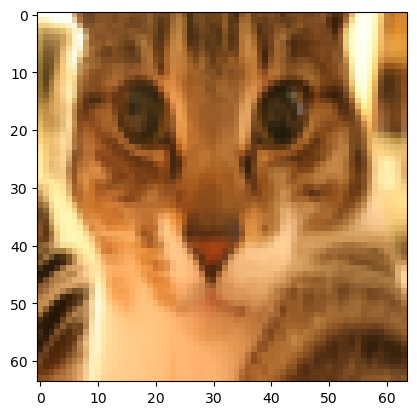

In [9]:
# Example of a picture that is rightly classified.
index = 3
plt.imshow(test_X_orig[:, index].reshape(64,64,3))
print(f"y = {int(test_Y[0,index])},  but y_pred = {int(neuron_model['test_Y_pred_out'][0,index])} so predicted that it is a '{classes[int(neuron_model['test_Y_pred_out'][0,index])].decode('utf-8')}' picture.")

y = 0, but y_pred = 1 so predicted that it is a 'cat' picture.


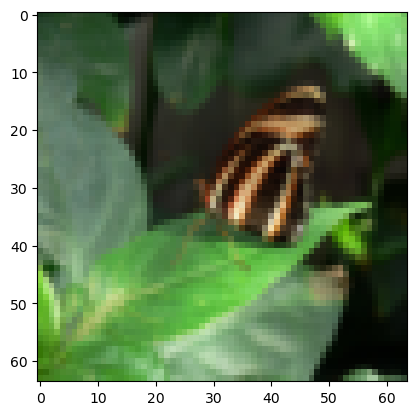

In [10]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_X_orig[:, index].reshape(64,64,3))
print(f"y = {int(test_Y[0,index])}, but y_pred = {int(neuron_model['test_Y_pred_out'][0,index])} so predicted that it is a '{classes[int(neuron_model['test_Y_pred_out'][0,index])].decode('utf-8')}' picture.")

Let's also plot the cost function and the gradients.

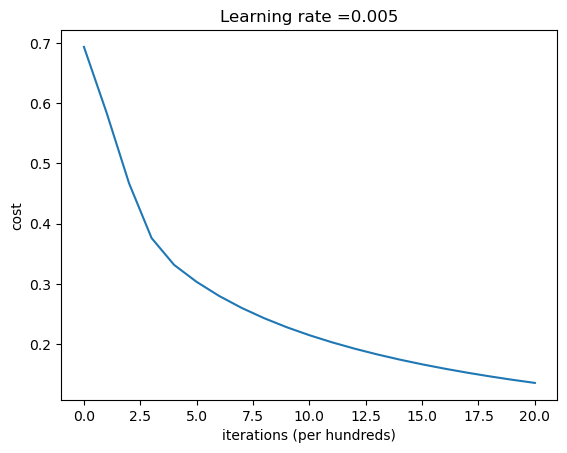

In [11]:
# Plot learning curve (with costs)
costs = np.squeeze(neuron_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(neuron_model["learning_rate"]))
plt.show()

**Interpretation**:
The cost decreasing shows that the parameters are being learned. However, could train the model even more on the training set. Increasing the number of iterations/epochs result in the training accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work, must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly change the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of `learning rates`. Run the cell below. 

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



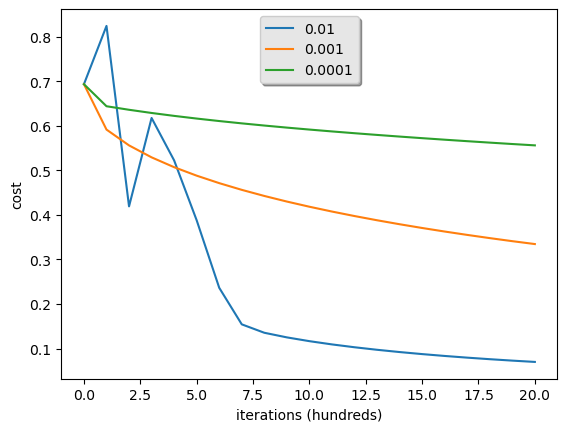

In [12]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = logistic_regression(train_X, train_Y, test_X, test_Y, num_epochs=2000, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If model overfits, use other techniques to reduce overfitting.


### Test with your own image ##

Use your own image and see the output of your model. To do that:<br>
1. Add image to this Jupyter Notebook's directory, in the "img" folder.<br>
2. Change your image's name in the following code.<br>
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!<br>

y = 0, neuron algorithm predicts a "non-cat" picture.


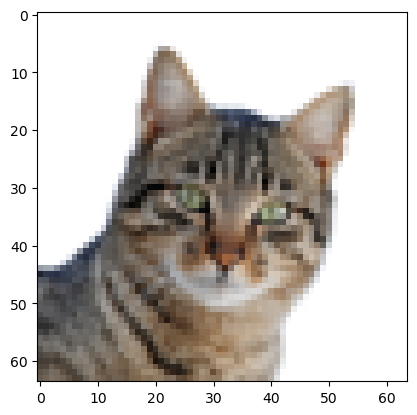

In [13]:
# change this to the name of your image file
my_image = "img/my_image_1.jpg"   

num_px = 64
# We preprocess the image to fit your algorithm.
image = np.array(Image.open(my_image).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

w=neuron_model["w"]; b=neuron_model["b"]
z = np.matmul(w.T,image)+b      # shape(1,m) --> (1,d)X(d,m)
Y_pred = 1/(1+np.exp(-z))              # shape(1,m)
my_image_pred = (Y_pred >0.5).astype(int)    # shape(1,m)

print(f"y = {int(my_image_pred.squeeze())}, neuron algorithm predicts a \"" + classes[int(my_image_pred.squeeze())].decode("utf-8") +  "\" picture.")

y = 1, neuron algorithm predicts a "cat" picture.


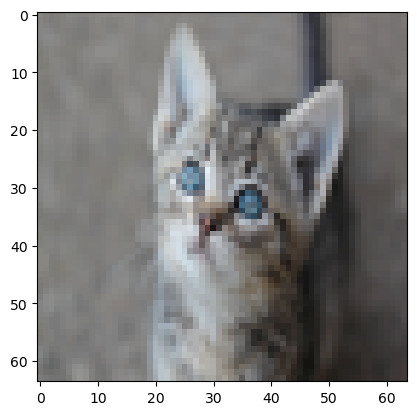

In [14]:
# change this to the name of your image file
my_image = "img/my_image_2.jpg"   

# We preprocess the image to fit your algorithm.
image = np.array(Image.open(my_image).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

w=neuron_model["w"]; b=neuron_model["b"]
z = np.matmul(w.T,image)+b      # shape(1,m) --> (1,d)X(d,m)
Y_pred = 1/(1+np.exp(-z))              # shape(1,m)
my_image_pred = (Y_pred >0.5).astype(int)    # shape(1,m)

print(f"y = {int(my_image_pred.squeeze())}, neuron algorithm predicts a \"" + classes[int(my_image_pred.squeeze())].decode("utf-8") +  "\" picture.")